#### **1. Overview**

**🎨 Generative Adversarial Networks (GANs): An Artistic Beginning**

In this project, we step into one of the most fascinating areas of deep learning — **Generative Adversarial Networks (GANs)**.  
GANs have transformed how we think about creativity and artificial intelligence. Instead of simply classifying or predicting, GANs *create* — they can generate **new, realistic, and original data** such as images, music, and even art.

Think of a GAN as a *creative duel* between two neural networks:
- 🧑‍🎨 **The Generator** tries to produce convincing fake images.
- 🕵️ **The Discriminator** tries to detect whether an image is real or fake.

Through this constant back-and-forth competition, both networks improve — the Generator becomes a better artist, and the Discriminator becomes a better critic.  
Eventually, the Generator learns to produce outputs that can **fool the Discriminator** — and us!

**🎯 Learning Objectives**

By the end of this notebook, we will:

1. Understand the **adversarial setup** of GANs — how the Generator and Discriminator learn together.  
2. Visualize and explore the **WikiArt subset dataset**, which contains diverse artistic styles.  
3. Implement and train a **minimal GAN** to generate art-like images from random noise.  
4. Observe how the Generator’s outputs evolve from noise → patterns → artistic textures over a few epochs.  
5. Reflect on what makes GAN training unique, unstable, and creatively challenging.

This notebook sets the foundation for the next three in this project series:

- **Notebook 2:** *Deep Convolutional GAN (DCGAN)* — we’ll replace the simple fully connected architecture with convolutional layers for realism.  
- **Notebook 3:** *Evaluating and Improving GANs* — we’ll learn how to measure diversity, realism, and mode collapse.  
- **Notebook 4:** *Creative GAN Exploration* — we’ll use pretrained models to create and manipulate art styles.


**🖼️ GAN Concept Diagram**


```text
        ┌──────────────────┐
        │   Random Noise   │
        │   (z ~ N(0,1))   │
        └──────┬───────────┘
               │
               ▼
        ┌────────────────┐
        │   Generator    │
        │     G(z)       │
        └──────┬─────────┘
               │   Fake Images
               ▼
        ┌───────────────┐
        │ Discriminator │
        │     D(x)      │
        └───────────────┘
        ▲         │
        │         ▼
  Real Images   "Fake or Real?"
        │
        └─────────────────────────→ Feedback to Generator
```

This loop continues until both models reach a dynamic equilibrium:
</br>the Discriminator can’t easily tell real art from generated art — that’s when we know the Generator has *learned something meaningful* about the artistic distribution.

**⚠️ Dataset Disclaimer – Downsampled WikiArt Subset**

In this notebook, we do not use the full WikiArt dataset (which contains ~80,000 paintings across dozens of styles).</br>
Instead, we use a curated, balanced, downsampled subset stored in the folder:

```text
WikiartSubsetDataset/
│
├── abstract_expressionism/
├── baroque/
├── cubism/
├── impressionism/
├── realism/
└── symbolism/
```

This subset:

- Contains approximately **8,000–10,000** total images.
- Is **balanced** — each of the six selected styles contributes roughly 1,200–1,500 images.
- Is **resized to 64×64 pixels**, making it feasible to train small GANs on CPU.
- Retains artistic diversity, allowing us to observe different textural and stylistic patterns.


>The dataset you’ll load is not the full WikiArt collection but a smaller, balanced subset.
</br>It was created to make GAN training faster and to ensure that the model learns from diverse art styles rather than collapsing toward the most common one.

---

#### **2. Understanding the GAN Framework**

**🎭 The Duel Between Two Networks**

A **Generative Adversarial Network (GAN)** is built on the idea of **competition and cooperation** between two neural networks:

- 🧑‍🎨 **Generator (G):**  
  The Generator starts with random noise and tries to **create fake images** that resemble real ones.  
  Its goal is to *fool* the Discriminator.

- 🕵️ **Discriminator (D):**  
  The Discriminator is like an art critic — it receives both real images (from the dataset) and fake ones (from the Generator)  
  and tries to **distinguish between real and fake**.

They play a continuous **adversarial game**:
- The Generator improves until the Discriminator can no longer tell which is real.
- The Discriminator sharpens its judgment to catch the Generator’s fakes.

This setup is beautifully simple yet incredibly powerful — it leads to models that can learn complex, high-dimensional distributions **without explicit supervision**.

**⚔️ The Adversarial Objective**

The training of GANs can be described as a **two-player minimax game**:

$$
\min_G \max_D V(D, G) =
\mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] +
\mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))]
$$

Let’s unpack this:

- The **Discriminator** $D(x)$ outputs a probability — how “real” the input looks.  
- The **Generator** $G(z)$ maps random noise $z$ (from a simple prior, e.g. $\mathcal{N}(0,1)$) to the data space.  
- The **first term** rewards $D$ for correctly identifying real images.  
- The **second term** penalizes $D$ for being fooled by $G$’s fake images.  
- Meanwhile, the Generator tries to *minimize* this overall loss, pushing $D(G(z))$ to be close to 1.

Over time:
- $D$ learns to distinguish fakes → helps $G$ improve.
- $G$ learns to generate more realistic samples → makes $D$’s job harder.

When both are strong, the system reaches an *equilibrium* where generated images look convincingly real.

**🧠 Intuitive Analogy – Forgers vs. Detectives**

Imagine an ongoing rivalry:

| Role | Analogy | Objective |
|:------|:---------|:------------|
| **Generator (G)** | A skilled **forger** creating imitation artworks | Produce images that look authentic |
| **Discriminator (D)** | A vigilant **detective** or art critic | Detect whether an artwork is real or fake |

As training progresses:
- The forger learns from feedback and improves their imitation skills.  
- The detective becomes better at spotting imperfections.  
- Eventually, the forgeries become so good that even the best critic struggles to tell them apart — that’s when the GAN has *converged*.

**Goals**

- **Discriminator’s goal:** Maximize the probability of correctly labeling real and fake samples.  
- **Generator’s goal:** Minimize the Discriminator’s ability to distinguish fakes.  
- The two networks train alternately — this push-and-pull is what gives GANs their generative power.

**🔍 Mathematical Intuition (Optional Deep Dive)**

When optimized perfectly:
- The Discriminator estimates the **optimal decision boundary** between real and fake data.  
- The Generator implicitly learns the **true data distribution**, $p_{data}(x)$.

At the ideal point of balance:
$$
p_g(x) = p_{data}(x)
$$

That is, the Generator’s distribution perfectly matches the real data distribution — meaning the generated images are statistically indistinguishable from real ones.

---

#### **3. Loading the Downsampled WikiArt Subset**

The dataset folder **`WikiartSubsetDataset/`** already contains a balanced, preprocessed subset of the original WikiArt collection.  
It includes approximately **8,000–10,000 total images**, distributed evenly across **six artistic styles**:

- Impressionism  
- Cubism  
- Abstract Expressionism  
- Realism  
- Baroque  
- Symbolism  

**Subset Preparation Summary:**  
This subset was created by:  
- Sampling roughly **1,300 images per class** to ensure balance  
- Resizing all images to **64×64 pixels** for efficient GAN training  
- Converting all images to **RGB** format  
- Saving them in separate subfolders, one per class (as required by `torchvision.datasets.ImageFolder`)

This smaller, curated dataset allows us to train simple GAN models quickly (even on CPU) while maintaining diversity across styles.

**Next Steps:**  
We will now:  
1. Load the dataset using `torchvision.datasets.ImageFolder`  
2. Print class names and sample counts  
3. Visualize a few example images to get an intuition for the data


In [12]:
# Step 1: Import libraries
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 2: Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Step 3: Load dataset
data_dir = "WikiartSubsetDataset/train"
wikiart_data = datasets.ImageFolder(root=data_dir, transform=transform)

# Step 4: Create DataLoader
data_loader = DataLoader(wikiart_data, batch_size=32, shuffle=True)

# Step 5: Print class names and sample counts
class_names = wikiart_data.classes
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}

print("Classes:", class_names)
print("Sample counts per class:")
for c, n in class_counts.items():
    print(f"  {c}: {n}")


Classes: ['expressionism', 'impressionism', 'post_impressionism', 'realism', 'romanticism', 'symbolism']
Sample counts per class:
  expressionism: 1500
  impressionism: 1500
  post_impressionism: 1500
  realism: 1500
  romanticism: 1500
  symbolism: 1500


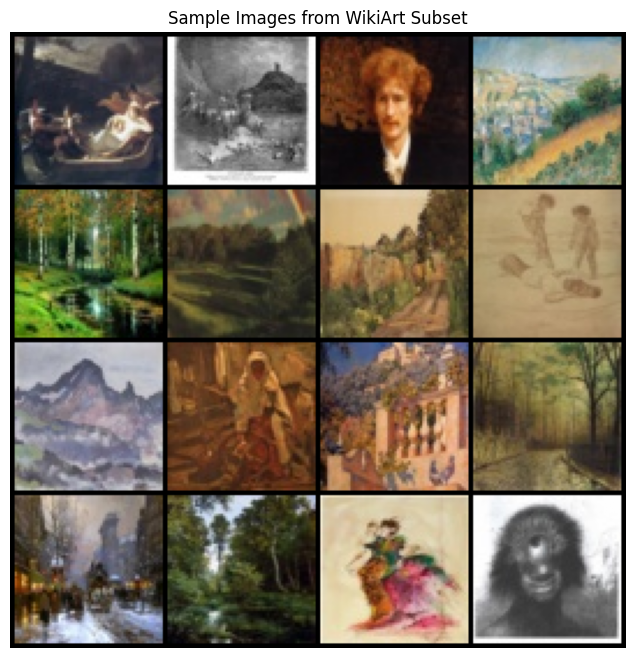

In [13]:
# Step 6: Visualize a few sample images

def imshow_grid(images, labels, classes, num_images=16):
    plt.figure(figsize=(8,8))
    images = images[:num_images]
    labels = labels[:num_images]
    grid_img = np.transpose(torchvision.utils.make_grid(images, nrow=4, padding=2, normalize=True), (1, 2, 0))
    plt.imshow(grid_img)
    plt.title("Sample Images from WikiArt Subset")
    plt.axis("off")
    plt.show()

import torchvision

# Fetch a batch
images, labels = next(iter(data_loader))
imshow_grid(images, labels, class_names)


**Reflection:**  
Take a moment to observe the visual diversity of the dataset.  
</br>How do the different artistic styles vary in terms of texture, color palette, and brushstroke patterns?  
</br>Understanding this diversity will help us appreciate what the Generator must learn to reproduce in later sections.

---

#### **4. Data Preparation for GAN Training**

Before we begin training our GAN, we must ensure that the input images and noise vectors are properly prepared for the Generator and Discriminator.  
This step is critical because **GANs are highly sensitive to data scaling and normalization** — incorrect preprocessing can make training unstable or even prevent convergence altogether.

**Why Normalize Images?**  
Most GAN architectures (including ours) use a **tanh** activation function in the final layer of the Generator.  
The `tanh` function outputs values in the range **[-1, 1]**, so to match this, we must normalize our real training images to the **same range**.  
This ensures that both real and generated images occupy a consistent value space, allowing the Discriminator to make meaningful comparisons.

Mathematically, normalization transforms pixel values from **[0, 1] → [-1, 1]** as:
$$
x_{norm} = 2x - 1
$$

**Latent Noise (z):**  
The Generator doesn’t start with an image — it starts with **random noise**.  
This noise vector, denoted as $ z $, is sampled from a standard normal distribution $ \mathcal{N}(0, 1) $ and typically has **100 dimensions**.  
During training, the Generator learns to transform this random noise into realistic images.

**Steps We’ll Take:**
1. Define the image transformations (resize, convert to tensor, normalize).
2. Create a DataLoader to feed mini-batches of images during training.
3. Visualize a few normalized samples to confirm the preprocessing.


In [14]:
# Step 1: Import libraries
import torch
import torchvision

# Step 2: Define image transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # scales pixels to [-1, 1]
])

# Step 3: Load the dataset with the new transform
data_dir = "WikiartSubsetDataset"
wikiart_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Step 4: Define a DataLoader
batch_size = 32
data_loader = DataLoader(wikiart_dataset, batch_size=batch_size, shuffle=True)

# Step 5: Verify batch shape
images, labels = next(iter(data_loader))
print(f"Batch shape: {images.shape}")
print(f"Pixel range after normalization: [{images.min():.2f}, {images.max():.2f}]")

Batch shape: torch.Size([32, 3, 64, 64])
Pixel range after normalization: [-1.00, 1.00]


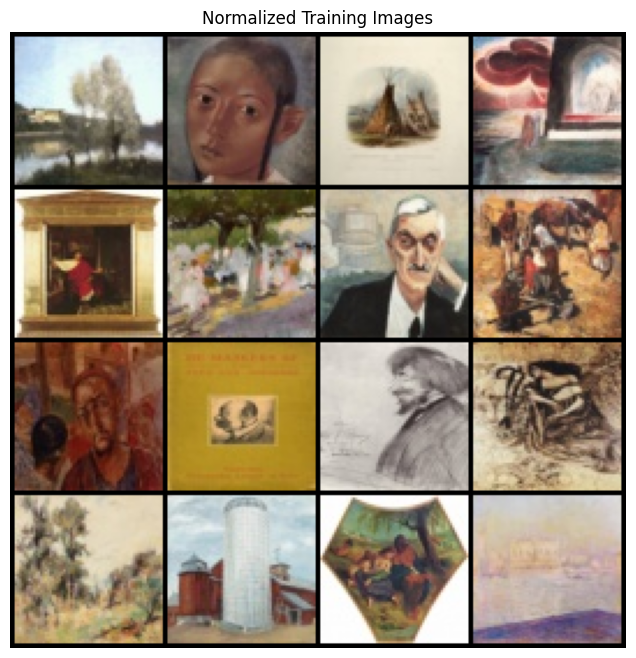

In [15]:
# Step 6: Visualize a few normalized images

def denorm(img_tensors):
    """Convert normalized tensors back to [0, 1] for visualization."""
    return img_tensors * 0.5 + 0.5

def show_images(images, num=16):
    plt.figure(figsize=(8,8))
    grid = torchvision.utils.make_grid(denorm(images[:num]), nrow=4)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title("Normalized Training Images")
    plt.axis("off")
    plt.show()

show_images(images)

**Understanding the Output:**

In the visualization above, each image has been:
- Resized to **64×64 pixels**
- Converted to a tensor suitable for PyTorch models
- Normalized to the range **[-1, 1]**  

Even though the images may look slightly darker or lower in contrast, that’s expected — it simply means normalization worked correctly.

**Latent Vector Setup:**

Each training iteration will also generate a random latent vector $ z \in \mathbb{R}^{100} $.  
The Generator uses these noise vectors as its “creative spark,” learning how to map them into structured visual patterns over time.


In [8]:
# Step 7: Define latent space dimensionality
latent_dim = 100

# Sample a few random noise vectors
z = torch.randn(5, latent_dim)
print(f"Shape of latent noise vector z: {z.shape}")

Shape of latent noise vector z: torch.Size([5, 100])


At this stage, we’ve prepared both sides of our GAN training pipeline:
- **Real images** (normalized to match the tanh output range)
- **Random noise vectors** (latent space input for the Generator)

---

#### **5. Building a Minimal GAN Architecture**

To make our first GAN concrete, we will implement a **very shallow CNN** pair — a **Generator** that upsamples random noise into $64\times 64$ color images, and a **Discriminator** that judges whether an input image looks real or fake. We keep the design intentionally small so we can focus on the **adversarial idea** rather than heavy engineering.

**Design intuition we will follow**

- **Generator ($G$):** start from a latent vector $z\in\mathbb{R}^{100}$ sampled from $\mathcal{N}(0,1)$, then **upsample** with `ConvTranspose2d` blocks, using **ReLU** activations and a **$\tanh$** at the end so outputs live in $[-1,1]$ (matching our preprocessing).
- **Discriminator ($D$):** take a $64\times 64$ RGB image and **downsample** with `Conv2d` blocks, using **LeakyReLU** (slope $=0.2$) and a final **Sigmoid** to output a probability.

**Layer-by-layer shapes**

```text
Generator G (input: z ∈ ℝ^100)
z  → Linear → 128×8×8  → ReLU
   → ConvTranspose2d(128→64, k=4, s=2, p=1)  → 64×16×16  → ReLU
   → ConvTranspose2d(64→32,  k=4, s=2, p=1)  → 32×32×32  → ReLU
   → ConvTranspose2d(32→3,   k=4, s=2, p=1)  → 3×64×64   → Tanh  (range [-1, 1])

Discriminator D (input: image 3×64×64)
3×64×64  → Conv2d(3→32,  k=4, s=2, p=1)  → 32×32×32 → LeakyReLU(0.2)
         → Conv2d(32→64, k=4, s=2, p=1)  → 64×16×16 → LeakyReLU(0.2)
         → Conv2d(64→128,k=4, s=2, p=1)  → 128×8×8  → LeakyReLU(0.2)
         → Flatten → Linear(128·8·8 → 1) → Sigmoid (probability “real”)
```

**Why these activations?**

- In $G$, **ReLU** encourages strong, sparse feature activations during upsampling, while $\tanh$ maps pixel predictions to $[-1,1]$ to align with our normalized dataset.
- In $D$, **LeakyReLU** avoids “dead” neurons during downsampling and helps gradients flow even when activations are negative. Sigmoid outputs a calibrated probability $\in (0,1)$.

We also use the common **DCGAN weight initialization** heuristic: convolutional weights $\sim \mathcal{N}(0, 0.02^2)$, biases $=0$. This tends to stabilize early adversarial training.

In [ ]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 100  # z ~ N(0,1)^100

# ---------------------------
# Generator
# ---------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.project = nn.Sequential(
            nn.Linear(z_dim, 128*8*8),
            nn.ReLU(True)
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8→16
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 16→32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # 32→64
            nn.Tanh()
        )

    def forward(self, z):
        x = self.project(z)                    # (N, 128*8*8)
        x = x.view(z.size(0), 128, 8, 8)       # (N, 128, 8, 8)
        x = self.upsample(x)                   # (N, 3, 64, 64)
        return x

# ---------------------------
# Discriminator
# ---------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),   # 64→32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32→16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16→8
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.features(x)
        out = self.classifier(h)
        return out

# ------------------------------------------
# Weight initialization (DCGAN-style)
# ------------------------------------------
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

G = Generator(latent_dim).to(device)
D = Discriminator().to(device)
G.apply(init_weights)
D.apply(init_weights)

print(G)
print(D)

Generator(
  (project): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU(inplace=True)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)
Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linea

**What to look for in the summaries we just printed**

- The **Generator** should end with an output of shape $[N, 3, 64, 64]$ and a final **$\tanh$** activation so pixel values are in $[-1, 1]$.
- The **Discriminator** should compress a $3\times 64\times 64$ image down to a **single probability** via **Sigmoid**.
- Both models are intentionally **small** so we can train short runs quickly and observe the adversarial dynamics.

In the next section, we will connect these models with a **training loop** that alternates between updating $D$ and $G$, and we will watch how samples evolve from pure noise to art-like textures over a few epochs.

---

#### **6. Training the Minimal GAN (Quick Run)**

Our goal here is **not** to train a perfect art generator, but to **observe** how the adversarial game unfolds over a few short epochs on CPU. We will alternate between improving the Discriminator $D$ and the Generator $G$, watch the **loss values**, and **visualize generated images** after each epoch to see the evolution from random noise → blurry blobs → emerging structure.

**Training dynamics in a nutshell**

- Step D: show $D$ real images (label 1) and fake images $G(z)$ (label 0), compute the Binary Cross Entropy loss, and update $D$ to better separate real vs fake.
- Step G: sample fresh noise $z$, generate $G(z)$, ask $D$ to score them as real (label 1), and update $G$ so its fakes look more real to $D$.

We will:
- run only 2–3 epochs to keep runtime reasonable,
- print losses every few batches,
- visualize a grid of generated samples after each epoch using a **fixed noise** vector (so we can see consistent progression).

**Why fixed noise helps**  
If we evaluate $G$ on *the same set of $z$ vectors* after each epoch, any improvement or regression in image quality becomes easy to spot.


Epoch [1/3] Batch [50/282] D_loss: 0.1063  G_loss: 3.0160
Epoch [1/3] Batch [100/282] D_loss: 0.1660  G_loss: 6.8454
Epoch [1/3] Batch [150/282] D_loss: 0.3620  G_loss: 6.1909
Epoch [1/3] Batch [200/282] D_loss: 0.1350  G_loss: 3.5921
Epoch [1/3] Batch [250/282] D_loss: 0.2295  G_loss: 2.8069


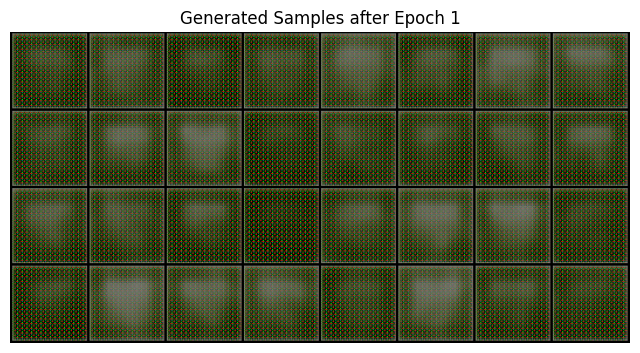

Epoch [2/3] Batch [50/282] D_loss: 0.5700  G_loss: 2.8541
Epoch [2/3] Batch [100/282] D_loss: 0.3573  G_loss: 2.4520
Epoch [2/3] Batch [150/282] D_loss: 0.2947  G_loss: 2.4243
Epoch [2/3] Batch [200/282] D_loss: 0.3567  G_loss: 2.0538
Epoch [2/3] Batch [250/282] D_loss: 0.5128  G_loss: 1.7884


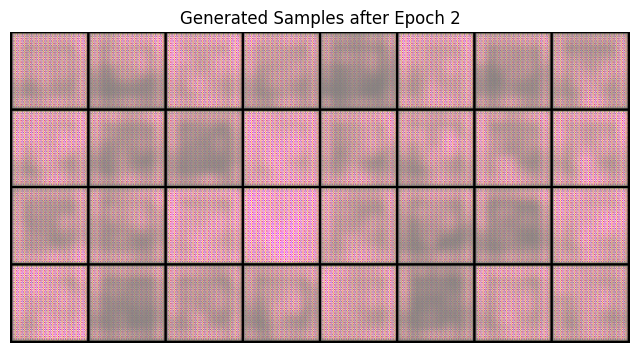

Epoch [3/3] Batch [50/282] D_loss: 0.2696  G_loss: 2.8541
Epoch [3/3] Batch [100/282] D_loss: 0.5476  G_loss: 2.5772
Epoch [3/3] Batch [150/282] D_loss: 0.0880  G_loss: 3.3208
Epoch [3/3] Batch [200/282] D_loss: 0.2802  G_loss: 2.0586
Epoch [3/3] Batch [250/282] D_loss: 0.7706  G_loss: 1.6934


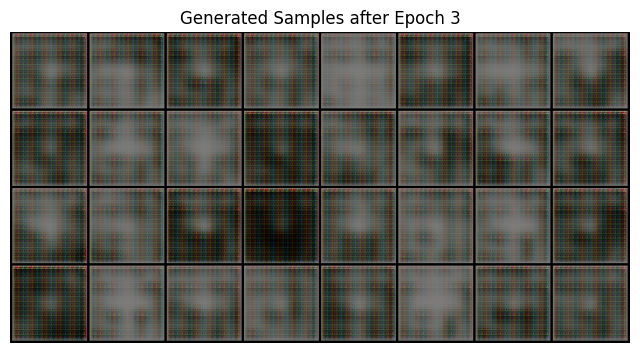

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Safety checks for variables defined in earlier sections
assert 'G' in globals() and 'D' in globals(), "Please run the model definition cell (Section 4) first."
assert 'data_loader' in globals(), "Please run the data loading cell (Section 2/3) first."
assert 'latent_dim' in globals(), "Please define latent_dim (e.g., latent_dim = 100) first."
device = "cuda" if torch.cuda.is_available() else "cpu"

# Loss and optimizers (DCGAN defaults for Adam)
criterion = nn.BCELoss()
lr = 2e-4
beta1 = 0.5
beta2 = 0.999
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

# Fixed noise for visualization across epochs
fixed_z = torch.randn(32, latent_dim, device=device)

# Utility: denormalize from [-1, 1] to [0, 1] for display
def denorm(x):
    return (x + 1) / 2

# Training parameters
epochs = 3
log_every = 50  # print frequency (batches)

G_losses, D_losses = [], []

for epoch in range(1, epochs + 1):
    G.train(); D.train()
    for i, (imgs, _) in enumerate(data_loader, start=1):
        # -------------------------
        # 1) Update Discriminator
        # -------------------------
        D.zero_grad()

        # Real images
        real = imgs.to(device)
        bsz = real.size(0)
        labels_real = torch.ones(bsz, 1, device=device)
        out_real = D(real)
        loss_real = criterion(out_real, labels_real)

        # Fake images (detach so gradients don't flow into G on D step)
        z = torch.randn(bsz, latent_dim, device=device)
        fake = G(z).detach()
        labels_fake = torch.zeros(bsz, 1, device=device)
        out_fake = D(fake)
        loss_fake = criterion(out_fake, labels_fake)

        # Total D loss and step
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        # -------------------------
        # 2) Update Generator
        # -------------------------
        G.zero_grad()

        z = torch.randn(bsz, latent_dim, device=device)
        gen = G(z)
        out = D(gen)
        # For G, we want D(gen) -> 1 (i.e., look real)
        labels_for_G = torch.ones(bsz, 1, device=device)
        loss_G = criterion(out, labels_for_G)
        loss_G.backward()
        optimizerG.step()

        # Logging
        if i % log_every == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch [{i}/{len(data_loader)}] "
                  f"D_loss: {loss_D.item():.4f}  G_loss: {loss_G.item():.4f}")

        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

    # -------------------------
    # Visualize after each epoch
    # -------------------------
    G.eval()
    with torch.no_grad():
        samples = G(fixed_z).cpu()
    grid = torchvision.utils.make_grid(denorm(samples), nrow=8, padding=2)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title(f"Generated Samples after Epoch {epoch}")
    plt.axis("off")
    plt.show()

In [11]:
# Save the model for reuse later (eg in NB02)
torch.save(G.state_dict(), "dcgan_min_generator_final.pth")
torch.save(D.state_dict(), "dcgan_min_discriminator_final.pth")

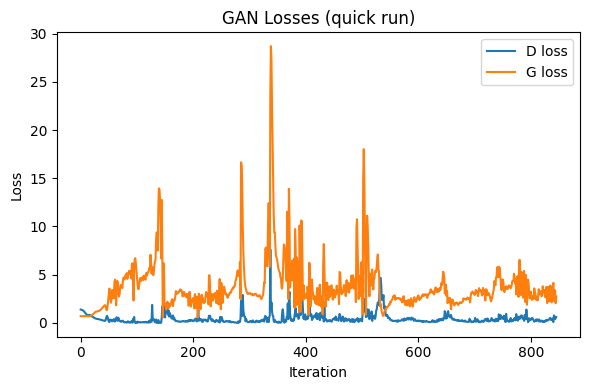

In [ ]:
# Optional: quick loss curves (useful to see general oscillations)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(D_losses, label="D loss")
plt.plot(G_losses, label="G loss")
plt.title("GAN Losses (quick run)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

**How to read what we see**

- Early on, generated images will look like **random noise**. After a few hundred iterations, we often start to see **blob-like textures** and coarse color layouts. With more training, these blobs can evolve into **brush-like patterns** and **style-specific textures**.
- The **loss curves** typically **oscillate** rather than steadily decrease. This is normal: the Generator and Discriminator are improving **against each other**. When one gets better, the other’s job becomes harder, and vice versa. We are observing a **moving target** rather than a single, fixed objective.

**Tips to improve results**

- Try a slightly smaller or larger learning rate.
- Increase batch size if memory allows.
- Train for a few more epochs, but keep expectations modest for this minimal model. In the next notebook, we will move to **DCGAN**, which is far better at capturing structure and style.

---

#### **7. Understanding Adversarial Dynamics**

Now that we have seen our minimal GAN in action, it’s important that we pause and **understand what is really happening behind the scenes**. The training of a GAN is not a straightforward optimization; it’s a dynamic game between two neural networks — the **Generator ($G$)** and the **Discriminator ($D$)** — each with conflicting objectives.

**The adversarial balance**

In each iteration:
- $D$ learns to **maximize** the probability of correctly labeling real images as real and fake images as fake.
- $G$ learns to **minimize** that same probability — it wants $D(G(z))$ to approach 1 (real).

Formally, as we said before, this can be written as:

$$
\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}}[\log D(x)] + \mathbb{E}_{z\sim p_z}[\log (1 - D(G(z)))]
$$

This forms a **two-player minimax game**, where each player’s progress depends on the other’s current strategy.  
If one improves too quickly, the other may fail to learn effectively.

**The need for balance**

A well-behaved GAN requires both $G$ and $D$ to learn at a comparable pace:

- If $D$ becomes **too strong**, it perfectly separates real and fake samples, giving gradients close to zero. The Generator stops learning — a phenomenon called **vanishing gradients**.
- If $G$ becomes **too strong**, it produces samples that easily fool $D$, so $D$ fails to recover meaningful signals about reality.
- The sweet spot is a **dynamic equilibrium**, where $G$ and $D$ continuously challenge each other but neither fully dominates.

This is why GAN training often requires careful tuning of learning rates, batch sizes, and update frequencies.

**Non-convergence and oscillation**

Unlike standard supervised learning, GANs do not necessarily **converge** to a fixed minimum.  
Because $G$ and $D$ are optimizing **opposing objectives**, the training tends to **oscillate** — loss values may fluctuate even when the quality of generated images improves.

A simplified intuition:
- $D$ learns to detect a flaw in $G$’s fake samples.
- $G$ adapts and fixes that flaw.
- Then $D$ finds a new flaw, restarting the cycle.

This **non-stationary objective** makes GANs both fascinating and challenging.

**Key takeaway**

Training a GAN is a careful dance:
- Too much power on one side leads to collapse.
- Balanced learning leads to emergent structure and realism.

In the next notebook, we will move from this minimal GAN toward a Deep Convolutional GAN (DCGAN) — a more stable and expressive architecture capable of generating strikingly realistic artwork.


---

#### **8. Reflection & Connection to Upcoming Notebooks**

In this notebook, we have taken our very first step into the world of **Generative Adversarial Networks (GANs)** — one of the most influential developments in deep learning for creativity and image synthesis.  
Let’s summarize what we have accomplished together:

- **Loaded and explored** a carefully balanced **WikiArt subset** (≈8–10K images across six art styles).  
  This subset ensures diversity and fairness across visual modes like Impressionism, Cubism, Realism, and more.  
- **Understood the core idea** of a GAN as a **two-player game** — a creative Generator ($G$) trying to fool a critical Discriminator ($D$).  
- **Implemented and trained** a **minimal GAN**, just enough to visualize how random noise evolves into structured artistic forms.  
- **Observed** how **adversarial feedback loops** cause oscillations in loss curves but lead to gradual improvement in sample quality.  

This foundational exercise helped us see **how GANs learn structure without explicit labels**, guided only by competition and feedback.

---